In [1]:
# Pkg.add("PyPlot")
# Pkg.add("DataFrames")
# Pkg.add("Requests")
# Pkg.add("TimeSeries")
# Pkg.add("MarketTechnicals")
# Pkg.add("DecisionTree")
# Pkg.add("Dates")
# Pkg.update()
# Pkg.build()

In [2]:
using PyPlot
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using DecisionTree


Use "Dict(a=>b for (a,b) in c)" instead.


In [3]:
function csvtotimearray(url, count=Void)
    df = readtable(Requests.get_streaming(url))
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=String[string(i) for i in DataFrames.names(df)]
    offset=(Void==count||count<1||count>length(DataFrames.names(df))-1)?(length(DataFrames.names(df))-2):(count-1)
    dataarray=convert(Array, df[end-offset:end])
    TimeArray(timestamp,dataarray,colnames[end-offset:end])
end
function yahoo(symbol, startdate)
    str="a=$(Dates.month(startdate)-1)"*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate, count=Void)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/$symbol.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=$str"
    csvtotimearray(url, count)
end
function renameta(series, columns)
    TimeArray(series.timestamp,series.values,columns)
end
function int2(value)
    floor(Int, value)
end

int2 (generic function with 1 method)

In [4]:
startdate=Date(2007,10,1) # set an early date to make use of all CBOE/GVZ data
# symbol="SPY" # SPY TLT GLD USO UUP
# ohlcv=yahoo(symbol, startdate)
symbol="YAHOO/INDEX_SPY"
ohlcv=quandl(symbol, startdate)
ohlcv.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [5]:
predictcount=252
rangelength=42
ta=ohlcv["Close"]
floattype=eltype(ta.values)

Float64

In [6]:
ustreasuryarray=renameta(quandl("USTREASURY/REALLONGTERM", startdate), ["USTREASURY/REALLONGTERM"])
ustreasuryarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [7]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
goldarray=TimeArray(gold.timestamp,gold.values./gold.values[1],["WGC/GOLD_DAILY_USD"])
goldarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [8]:
oilarray=renameta(quandl("OPEC/ORB", startdate)["Value"], ["OPEC/ORB"])
oilarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [9]:
eurusdarray=renameta(quandl("ECB/EURUSD", startdate)["Value"], ["ECB/EURUSD"])
eurusdarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [10]:
# CBOE/GVZ since 2008-6-3
half=int2(rangelength/3) # short period for smoothing
gvzarray=renameta(ema(quandl("CBOE/GVZ", startdate)["GVZ"], half), ["CBOE/GVZ.ema$half"])
gvzarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2008-06-20
 2016-10-03

In [11]:
# CBOE/EVZ since 2007-11-01
evzarray=renameta(ema(quandl("CBOE/EVZ", startdate)["EVZ"], half), ["CBOE/EVZ.ema$half"])
evzarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-11-21
 2016-10-03

In [12]:
# CBOE/OVX since 2007-05-10
ovxarray=renameta(ema(quandl("CBOE/OVX", startdate)["USO_VIX_OVX_"], half), ["CBOE/OVX.ema$half"])
ovxarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-18
 2016-10-03

In [13]:
aaii_weekly=quandl("AAII/AAII_SENTIMENT", startdate)
aaii_weekly.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-04
 2016-09-29

In [14]:
usleading_weekly=quandl("ECRI/USLEADING", startdate)
usleading_weekly.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-05
 2016-09-23

In [15]:
# a copy of function overlaps in https://github.com/JuliaStats/TimeSeries.jl/blob/master/src/utilities.jl
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end
# replacement for function merge in https://github.com/JuliaStats/TimeSeries.jl/blob/master/src/combine.jl
function merge2(ta1, ta2, col_names=Void)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, Void==col_names?[ta1.colnames; ta2.colnames]:col_names)
end
function ema_all(ta, n=42, p="")
    half=int2(n/2)
    t0=ema(ta, half)
    t1=ema(ta, n)
    t2=ema(ta, n*2)
    t3=ema(ta, n*4)
    r=merge2(t0, t1)
    r=merge2(r, t2)
    r=merge2(r, t3)
    r2=merge2(t1.-t0, t2.-t1)
    r2=merge2(r2, t3.-t2)
    merge2(r, r2, [p*"ema$half", p*"ema$n", p*"ema$(n*2)", p*"ema$(n*4)", p*"ema$n-ema$half", p*"ema$(n*2)-ema$n", p*"ema$(n*4)-ema$(n*2)"])
end
function weekly_to_daily(weekly, daily)
    width=length(weekly.colnames)
    merged=merge2(weekly,daily)
    series=daily[merged.timestamp[1]:merged.timestamp[end]]
    sentiment=zeros(length(series),length(merged.colnames))
    for i in merged.timestamp
        idx1=searchsortedfirst(series.timestamp,i)
        idx2=searchsortedfirst(merged.timestamp,i)
        sentiment[idx1,:]=merged.values[idx2,:]
    end
#     # linear interpolation of 2 adjacent values
#     for i=2:length(merged.timestamp)
#         i1=merged.timestamp[i-1]
#         i2=merged.timestamp[i]
#         idx1=searchsortedfirst(series.timestamp,i1)
#         idx2=searchsortedfirst(series.timestamp,i2)
#         span=idx2-idx1
#         d=1/span
#         ds=collect(linspace(d,1-d,span-1))
#         for i=1:length(ds)
#             alpha=ds[i]
#             sentiment[idx1+i,:]=(1-alpha).*sentiment[idx1,:].+alpha.*sentiment[idx2,:]
#         end
#     end
#     last=searchsortedfirst(series.timestamp,merged.timestamp[end])
    last=1
    for i=last+1:size(sentiment,1)
        if sentiment[i,1]==0
            sentiment[i,:]=sentiment[i-1,:]
        end
    end
    TimeArray(series.timestamp,sentiment[:,1:width],merged.colnames[1:width])
end
function pad_daily(merged, daily)
    idx=searchsortedfirst(daily.timestamp, merged.timestamp[end])
    times=daily.timestamp[idx+1:end]
    n=length(times)
    if n>0
        values=merged.values[end,:]
        for i=2:n
            values=[values merged.values[end,:]]
        end
        values=transpose(values)
        TimeArray([merged.timestamp;times], [merged.values;values], merged.colnames)
    else
        TimeArray(merged.timestamp, merged.values, merged.colnames)
    end
end
function to_daily_and_pad(weekly, daily)
    merged=weekly_to_daily(weekly, daily)
    pad_daily(merged, daily)
end

to_daily_and_pad (generic function with 1 method)

In [16]:
ushybond=renameta(quandl("ML/HYOAS", startdate), ["ML/HYOAS"])
usaabond=renameta(quandl("ML/AAOAS", startdate), ["ML/AAOAS"])
[ushybond.timestamp[[1,end]] usaabond.timestamp[[1,end]]]

2×2 Array{Date,2}:
 2007-10-01  2007-10-01
 2016-09-30  2016-09-30

In [17]:
ushybondarray=pad_daily(ushybond, ta)
usaabondarray=pad_daily(usaabond, ta)
usyieldspreadarray=renameta(ushybondarray.-usaabondarray, ["ML/HYOAS-ML/AAOAS"])
usyieldspreadarray.timestamp[[1,end]]

2-element Array{Date,1}:
 2007-10-01
 2016-10-03

In [18]:
aaii=to_daily_and_pad(aaii_weekly, ta)
aaiiarray=TimeArray(aaii.timestamp, aaii.values[:,[1:3;5:6]], ["AAII/AAII_SENTIMENT.Bullish","AAII/AAII_SENTIMENT.Neutral","AAII/AAII_SENTIMENT.Bearish","AAII.Bullish_8_Week_Mov_Avg","AAII.Bull_Bear_Spread"])
usleadingarray=renameta(to_daily_and_pad(usleading_weekly, ta), ["ECRI/USLEADING.Level", "ECRI/USLEADING.Growth"])
vxtharray=renameta(quandl("CBOE/VXTH", startdate), ["CBOE/VXTH"])
tyvixarray=renameta(ema(quandl("CBOE/TYVIX", startdate, 1), half), ["CBOE/TYVIX.ema$half"])
vvix=quandl("CBOE/VVIX", startdate)
vvixarray2=merge2(vvix["VVIX"], ema(vvix, half), ["CBOE/VVIX", "CBOE/VVIX.ema$half"])
vix=quandl("CBOE/VIX", startdate)
vixarray2=merge2(vix["VIX_Close"], ema(vix, half), ["CBOE/VIX", "CBOE/VIX.ema$half"])
vxv=quandl("CBOE/VXV", startdate)
vxvarray2=merge2(vxv["CLOSE"], ema(vxv, half), ["CBOE/VXV", "CBOE/VXV.ema$half"])
vvixarray=vvixarray2["CBOE/VVIX.ema$half"]
vixarray=vixarray2["CBOE/VIX.ema$half"]
vxvarray=vxvarray2["CBOE/VXV.ema$half"]
tmp=merge2(ema_all(eurusdarray, rangelength, "ECB/EURUSD."), ema_all(goldarray, rangelength, "WGC."))
tmp=merge2(tmp, ema_all(oilarray, rangelength, "OPEC/ORB."))
tmp=merge2(tmp, ema_all(ustreasuryarray, rangelength, "USTREASURY."))
emaarray=merge2(tmp, ema_all(vxtharray, rangelength, "CBOE/VXTH."))
[emaarray.timestamp[[1,end]] [size(emaarray.values)[1]; size(emaarray.values)[2]]]

2×2 Array{Any,2}:
 2008-06-03  2067
 2016-10-03    35

In [19]:
function aroon(ta, n=25)
    up=moving(ta,x->findlast(x,maximum(x))/length(x),n)
    down=moving(ta,x->findlast(x,minimum(x))/length(x),n)
    d=up.-down
    r=merge2(up,down)
    r=merge2(r,d)
    TimeArray(r.timestamp,r.values,["aroon$n.up","aroon$n.down","aroon$n.up-down"])
end
function volumeoscillator(ohlcv, n=28, c="Volume")
    volume=ohlcv[c]
    vshort=ema(volume, int2(n/2))
    vlong=ema(volume, n)
    volumeoscillator=(vshort.-vlong)./vlong
    TimeArray(volumeoscillator.timestamp,volumeoscillator.values,["VolumeOscillator$n"])
end
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf$n"], ohlcv.meta)
end
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge2(upband, dnband) 
    merge2(bands, tama, ["up", "down", "mean"])
end
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=merge2(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev$n,$width", "bbstd$n,$width"])
end
function bollingerbands_all(ta, n=20, width=2)
    b1=bollingerbands_deviation(ta, n, width)
    b2=bollingerbands_deviation(ta, n*2, width)
    b3=bollingerbands_deviation(ta, n*4, width)
    r=merge2(b1, b2)
    merge2(r, b3)
end
function vwap_divergence(ohlcv, n=28)
    v1=vwap(ohlcv, int2(n/2))
    v2=vwap(ohlcv, n)
    v3=vwap(ohlcv, n*2)
    v4=vwap(ohlcv, n*4)
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["vwap$(int2(n/2))","vwap$n","vwap$(n*2)","vwap$(n*4)","vwap$(int2(n/2))-$n","vwap$n-$(n*2)","vwap$(n*2)-$(n*4)"]#,"vwap$(n*8)","vwap$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close", real=floattype)
    highs = merge2(ohlc[h], lag(ohlc[c]))
    lows = merge2(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr$n"], ohlc.meta)
end
function atr_divergence(ohlcv, n=28)
    v1=averagetruerange(ohlcv,int2(n/2));
    v2=averagetruerange(ohlcv,n);
    v3=averagetruerange(ohlcv,n*2);
    v4=averagetruerange(ohlcv,n*4);
    d1=v1.-v2
    d2=v2.-v3
    d3=v3.-v4
    ta=merge2(v1,v2)
    ta=merge2(ta,v3)
    ta=merge2(ta,v4)
    ta=merge2(ta,d1)
    ta=merge2(ta,d2)
    ta=merge2(ta,d3)
    cname=["atr$(int2(n/2))","atr$n","atr$(n*2)","atr$(n*4)","atr$(int2(n/2))-$n","atr$n-$(n*2)","atr$(n*2)-$(n*4)"]#,"atr$(n*8)","atr$(n*4)-$(n*8)"]
    TimeArray(ta.timestamp,ta.values,cname)
end
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume", real=floattype)
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pv=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nv=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pv,sum,n)
    nsum=moving(nv,sum,n)
    re=psum./(psum.+nsum)
    TimeArray(re.timestamp, re.values, ["mfi$n"], ohlcv.meta)
end
function rsi_mfi_all(ohlcv, n=28, c="Close")
    ta=ohlcv[c]
    r=rsi(ta,n)
    r1=TimeArray(r.timestamp,r.values./100,r.colnames)
    m1=moneyflowindex(ohlcv,n)
    merge2(r1,m1)
end
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    r = merge2(mcd, sig, ["macd($fast,$slow,$signal)", "signal"])
#     merge(r, mcd .- sig, col_names=[r.colnames; ["histogram"]])
end
function priceindex(ta, n=28)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge2(low, high, ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=merge2(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["priceindex$n"]])
end

priceindex (generic function with 2 methods)

In [20]:
rsimfiarray=rsi_mfi_all(ohlcv,rangelength);
macdarray=macd2(ta,int2(rangelength/2),rangelength);
vwaparray=vwap_divergence(ohlcv,rangelength);
atrarray=atr_divergence(ohlcv,rangelength);
aroonarray=aroon(ta,rangelength);
volumeoscillatorarray=volumeoscillator(ohlcv,rangelength);
cmfarray=chaikinmoneyflow(ohlcv,rangelength);
bbarray=bollingerbands_all(ta,rangelength,2);
priceindexarray=priceindex(ta,rangelength);

In [21]:
featurearray=merge2(bbarray,cmfarray);
featurearray=merge2(featurearray,macdarray);
featurearray=merge2(featurearray,volumeoscillatorarray);
featurearray=merge2(featurearray,rsimfiarray);
featurearray=merge2(featurearray,aroonarray);
featurearray=merge2(featurearray,atrarray);
featurearray=merge2(featurearray,vwaparray);
featurearray=merge2(featurearray,ustreasuryarray);
featurearray=merge2(featurearray,ushybondarray);
featurearray=merge2(featurearray,usaabondarray);
featurearray=merge2(featurearray,usyieldspreadarray);
featurearray=merge2(featurearray,tyvixarray);
featurearray=merge2(featurearray,vxtharray);
featurearray=merge2(featurearray,vvixarray);
featurearray=merge2(featurearray,vixarray);
featurearray=merge2(featurearray,vxvarray);
featurearray=merge2(featurearray,goldarray);
featurearray=merge2(featurearray,gvzarray);
featurearray=merge2(featurearray,oilarray);
featurearray=merge2(featurearray,ovxarray);
featurearray=merge2(featurearray,eurusdarray);
featurearray=merge2(featurearray,evzarray);
featurearray=merge2(featurearray,aaiiarray);
featurearray=merge2(featurearray,usleadingarray);
featurearray=merge2(featurearray,emaarray);

In [22]:
withlabel=merge2(featurearray,priceindexarray)
withoutlabel=merge2(featurearray,ta)
withoutlabel.timestamp[[1,end]]

2-element Array{Date,1}:
 2008-06-20
 2016-10-03

In [23]:
dataoffset=length(withoutlabel)-length(withlabel)
lastdate=withlabel.timestamp[end]
lastdateidx=searchsortedfirst(withoutlabel.timestamp, lastdate)
splitidx=lastdateidx-predictcount+dataoffset
newfeatures=TimeArray(withoutlabel.timestamp[splitidx+1:end],withoutlabel.values[splitidx+1:end,:],withoutlabel.colnames)
training=TimeArray(withlabel.timestamp[1:splitidx],withlabel.values[1:splitidx,:],withlabel.colnames)
test=TimeArray(withlabel.timestamp[splitidx+1:end],withlabel.values[splitidx+1:end,:],withlabel.colnames)
test.timestamp[[1,end]]

2-element Array{Date,1}:
 2015-09-30
 2016-08-04

In [24]:
rsiidx=findfirst(withlabel.colnames, "rsi")
mfiidx=findfirst(withlabel.colnames, "mfi$rangelength")
atridx=findfirst(withlabel.colnames, "atr$rangelength")
vxvidx=findfirst(withlabel.colnames, "CBOE/VXV.ema$half")
bbsidx=findfirst(withlabel.colnames, "AAII.Bull_Bear_Spread")
priceidx=findfirst(withlabel.colnames, "priceindex$rangelength")
closeidx=findfirst(withlabel.colnames, "Close")

87

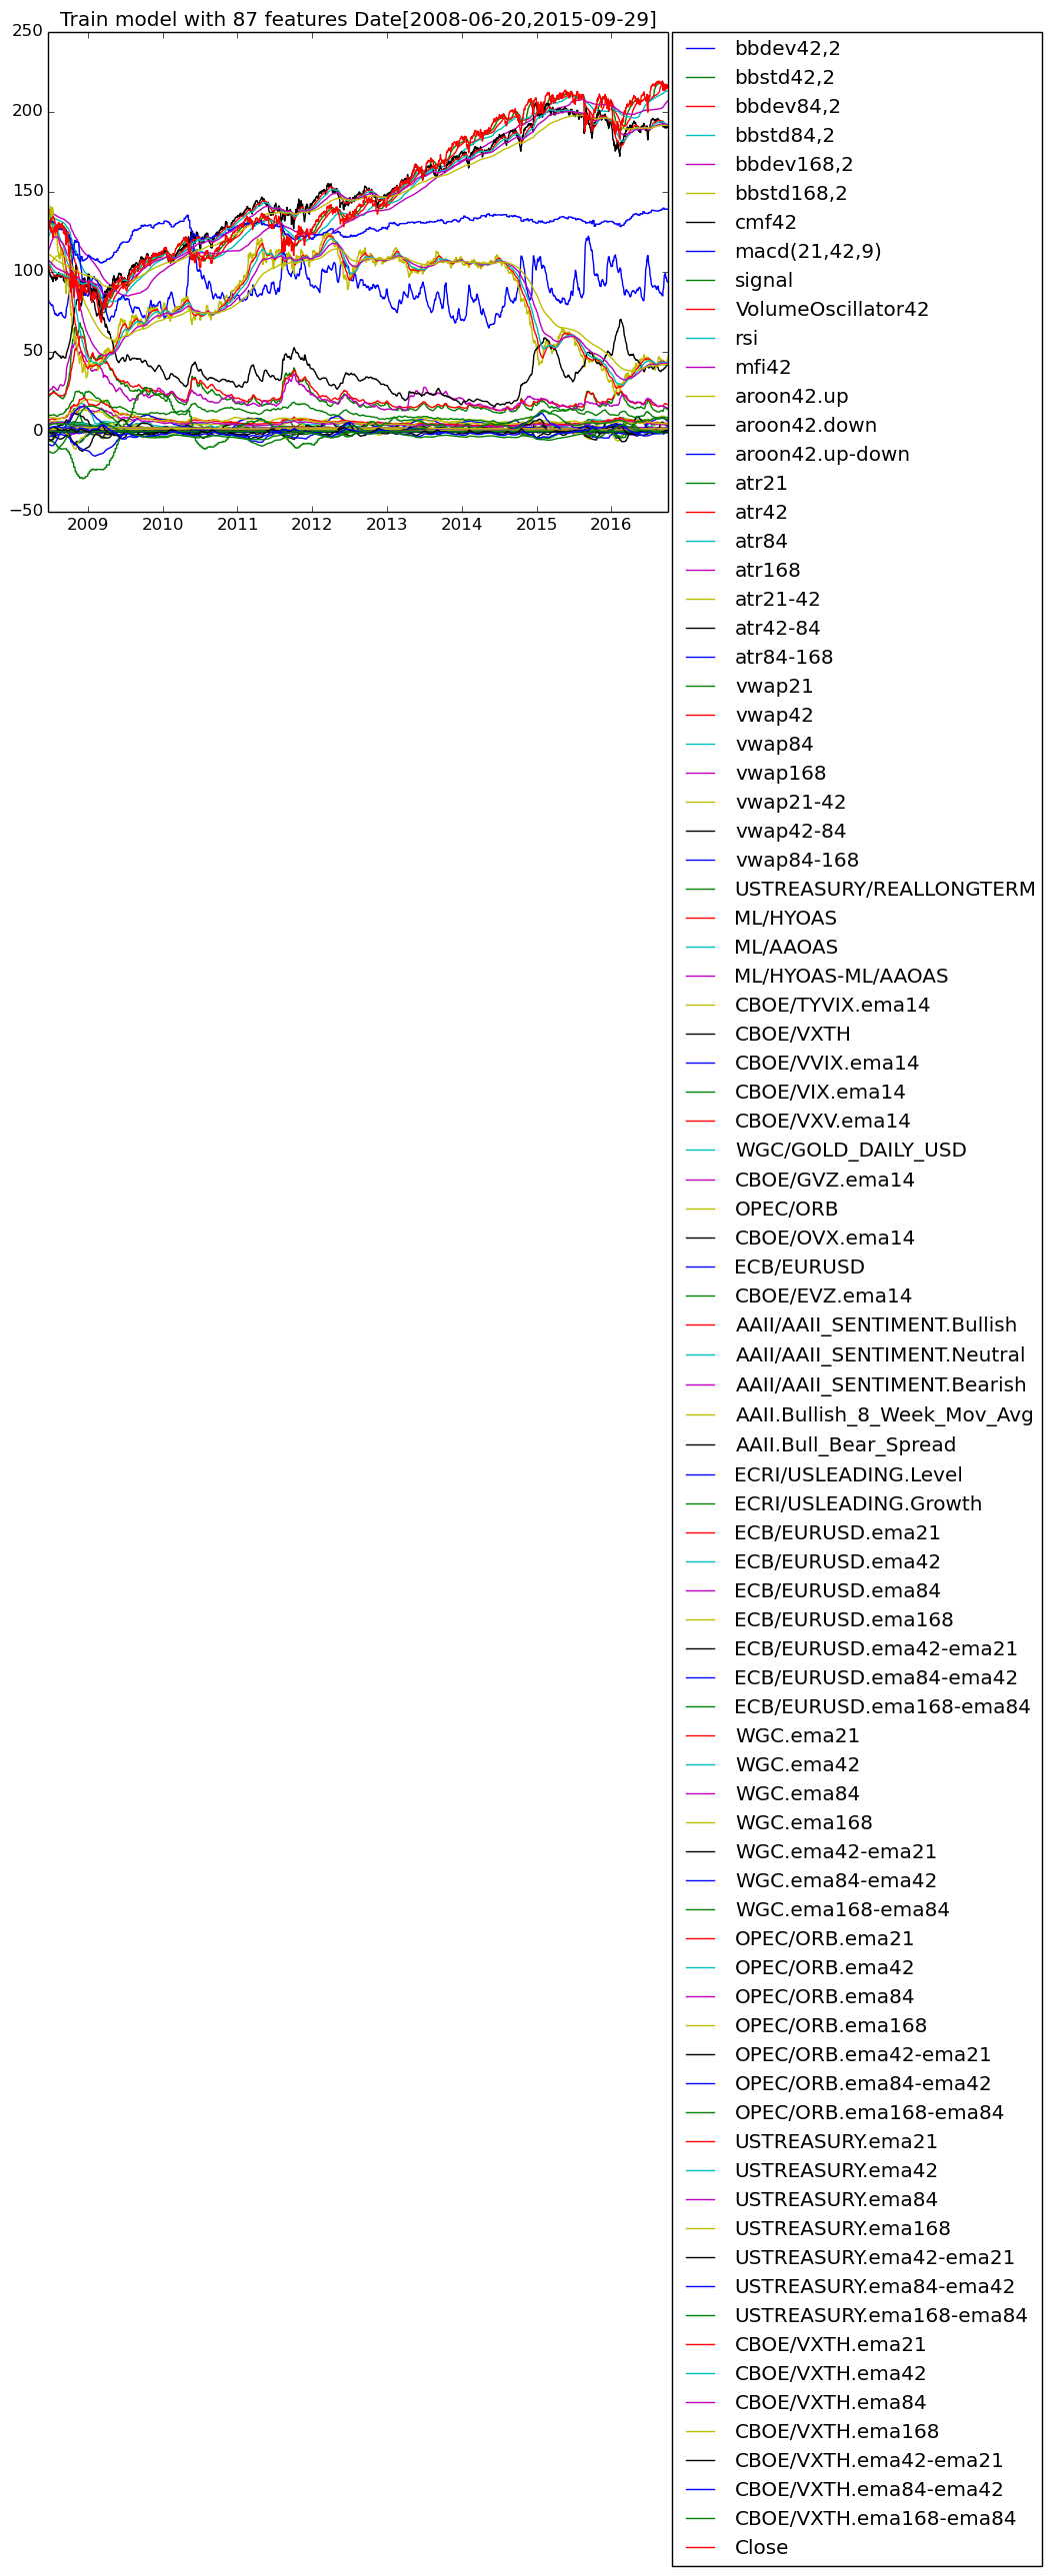

PyObject <matplotlib.text.Text object at 0x7f2348aa1510>

In [25]:
plot(withoutlabel.timestamp,withoutlabel.values)
legend(withoutlabel.colnames,bbox_to_anchor=(1.62, 1.02))
title("Train model with $closeidx features $(training.timestamp[[1,end]])")

In [26]:
ntrees=100
features=training.values[:,1:closeidx]
randomfeaturenum=ceil(Int, sqrt(closeidx))
labels=convert(Array{Float64,1},training.values[:,priceidx])
# train regression forest, using sqrt(number of features) random features, 100 trees,
# averaging of 5 samples per leaf (optional), 0.7 of samples per tree (optional)
model = build_forest(labels, features, randomfeaturenum, ntrees, 5, 0.7)

  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /home/juser/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /opt/julia_packages/

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 438.92
Avg Depth:  30.65

In [27]:
newlabels=apply_forest(model, newfeatures.values);
initvalue=withlabel.values[1,closeidx];

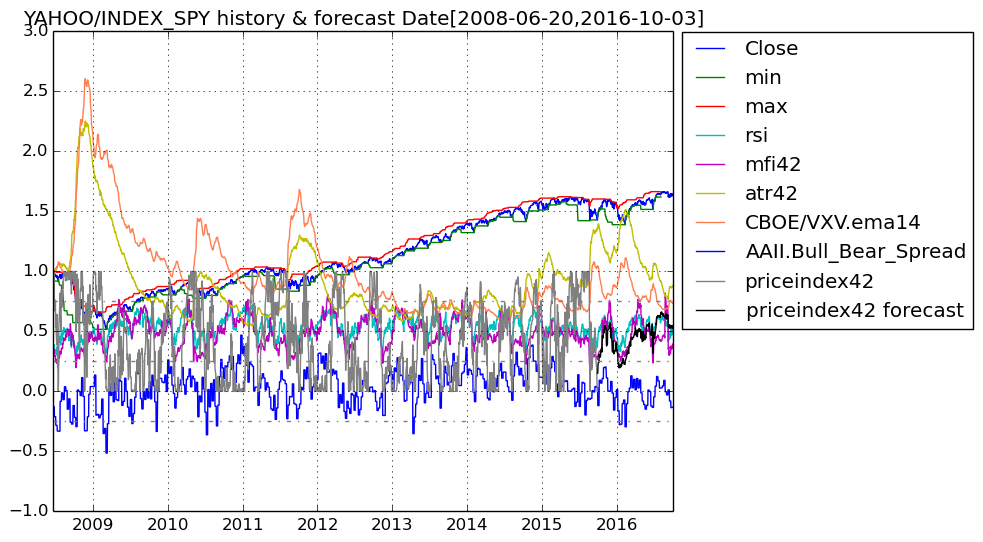

PyObject <matplotlib.legend.Legend object at 0x7f2348220cd0>

In [28]:
plot(withoutlabel.timestamp,withoutlabel.values[:,closeidx]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,closeidx+1:closeidx+2]./initvalue)
plot(withoutlabel.timestamp,withoutlabel.values[:,rsiidx])
plot(withoutlabel.timestamp,withoutlabel.values[:,mfiidx])
plot(withoutlabel.timestamp,withoutlabel.values[:,atridx]./withoutlabel.values[1,atridx])
plot(withoutlabel.timestamp,withoutlabel.values[:,vxvidx]./withoutlabel.values[1,vxvidx],c="Coral")
plot(withoutlabel.timestamp,withoutlabel.values[:,bbsidx])
plot(training.timestamp,training.values[:,priceidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
title("$symbol history & forecast $(withoutlabel.timestamp[[1,end]])")
grid("on")
axhline(y=-0.25,ls="-.",c="Grey")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")
legend([withlabel.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,atridx,vxvidx,bbsidx,priceidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))

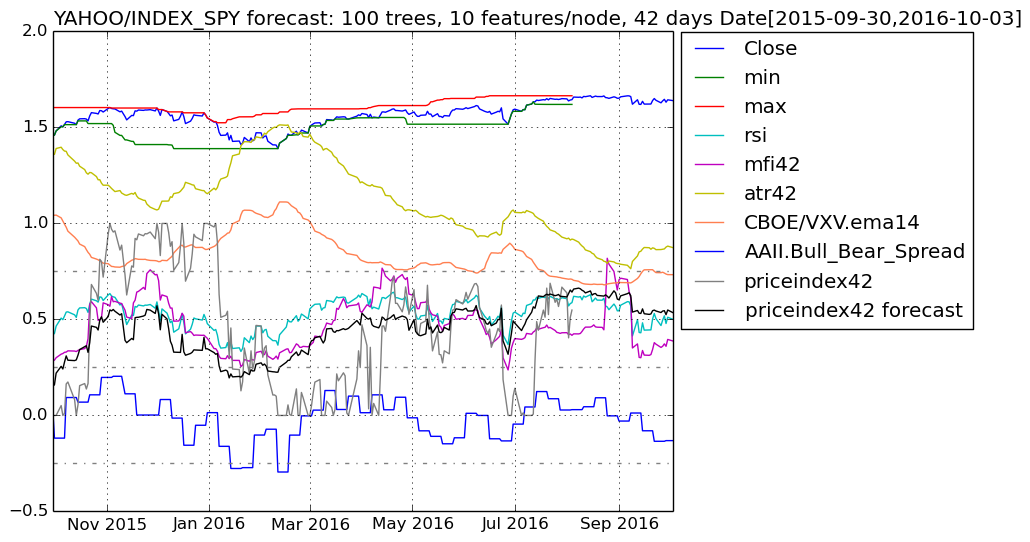

PyObject <matplotlib.lines.Line2D object at 0x7f234802ee10>

In [29]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue)
plot(test.timestamp,test.values[:,closeidx+1:closeidx+2]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,rsiidx])
plot(newfeatures.timestamp,newfeatures.values[:,mfiidx])
plot(newfeatures.timestamp,newfeatures.values[:,atridx]./withoutlabel.values[1,atridx])
plot(newfeatures.timestamp,newfeatures.values[:,vxvidx]./withoutlabel.values[1,vxvidx],c="Coral")
plot(newfeatures.timestamp,newfeatures.values[:,bbsidx])
plot(test.timestamp,test.values[:,priceidx],c="Grey")
plot(newfeatures.timestamp,newlabels,c="k")
legend([test.colnames[[closeidx,closeidx+1,closeidx+2,rsiidx,mfiidx,atridx,vxvidx,bbsidx,priceidx]];"priceindex$rangelength forecast"],bbox_to_anchor=(1.5, 1.02))
title("$symbol forecast: $ntrees trees, $randomfeaturenum features/node, $rangelength days $(newfeatures.timestamp[[1,end]])", loc="left")
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.axhline
axhline(y=-0.25,ls="-.",c="Grey")
axhline(y=0.25,ls="-.",c="Grey")
axhline(y=0.75,ls="-.",c="Grey")

In [30]:
features=withlabel.values[:,1:closeidx]
labels=convert(Array{Float64,1},withlabel.values[:,priceidx])
# run n-fold cross validation on regression forest
# using 2 random features, 10 trees, 3 folds, averaging of 5 samples/leaf (optional),
# and 0.7 porition of samples per tree (optional)
# returns array of coefficients of determination (R^2)
r2 = nfoldCV_forest(labels, features, 2, ntrees, 3, 5, 0.7)


Fold 1
Mean Squared Error:     0.014223813020761287
Correlation Coeff:      0.9469233705611833
Coeff of Determination: 0.8692589889371432

Fold 2
Mean Squared Error:     0.013609144779382772
Correlation Coeff:      0.945900623295796
Coeff of Determination: 0.871852067358602

Fold 3
Mean Squared Error:     0.013001991404043354
Correlation Coeff:      0.9484130855432567
Coeff of Determination: 0.8805596711384951

Mean Coeff of Determination: 0.87389024247808


3-element Array{Float64,1}:
 0.869259
 0.871852
 0.88056 

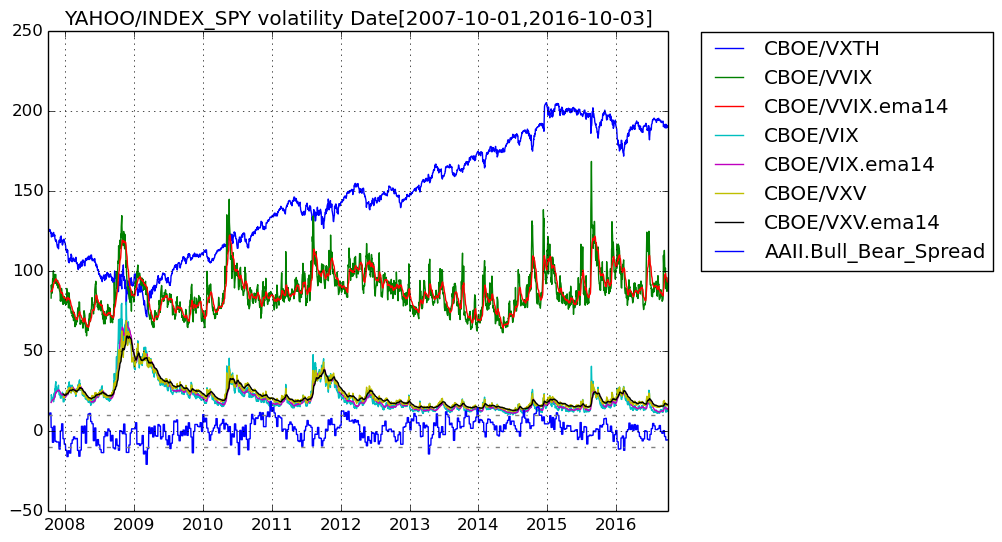

PyObject <matplotlib.text.Text object at 0x7f233b5966d0>

In [31]:
plot(vxtharray.timestamp, vxtharray.values)
plot(vvixarray2.timestamp, vvixarray2.values)
plot(vixarray2.timestamp, vixarray2.values)
plot(vxvarray2.timestamp, vxvarray2.values)
plot(aaiiarray.timestamp, aaiiarray["AAII.Bull_Bear_Spread"].values.*40)
legend(["CBOE/VXTH","CBOE/VVIX","CBOE/VVIX.ema$half","CBOE/VIX","CBOE/VIX.ema$half","CBOE/VXV","CBOE/VXV.ema$half","AAII.Bull_Bear_Spread"],bbox_to_anchor=(1.54, 1.02))
grid("on")
axhline(y=10,ls="-.",c="Grey")
axhline(y=-10,ls="-.",c="Grey")
title("$symbol volatility $(vxtharray.timestamp[[1,end]])")